In [ ]:
# %pip install pinecone
# %pip install groq
# %pip install sentence-transformers
# %pip install --upgrade langchain
# %pip install pypdf
# %pip install langchain-pinecone
# %pip install langchain-groq
# %pip install -quiet --upgrade langchain-text-splitters langchain-community
# %pip install langgraph

In [15]:
import os
import re
from typing_extensions import List, TypedDict

from sentence_transformers import SentenceTransformer

from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_pinecone import PineconeVectorStore
from langchain import hub
from langgraph.graph import START, StateGraph, END
from langchain_core.documents import Document
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate

from pinecone import Pinecone, ServerlessSpec

import streamlit as st

In [4]:
device = "cpu"

## Extracción de PDF a texto

In [5]:
# Lee todos los archivos PDF en el directorio indicado
def read_doc(directory):
    file_loader=PyPDFDirectoryLoader(directory)
    documents = file_loader.load()
    return documents

doc=read_doc("./")

Cada documento irá en un índice diferente de la variable doc. Admeás, con la metadata se puede obtener a quién pertenece

In [6]:
doc[0].metadata

{'source': 'CV_Elon_Musk.pdf', 'page': 0}

## Conversión de texto a embeddings

In [7]:
embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)

## Carga de documentos en la base de datos

Separación de documentos en chunks

In [8]:
def chunk_data(docs, chunk_size=800, chunk_overlap=50):
    text_splitter=RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    doc=text_splitter.split_documents(docs)
    return doc

documents=chunk_data(docs=doc,chunk_size=500, chunk_overlap=50)

documents

[Document(metadata={'source': 'CV_Elon_Musk.pdf', 'page': 0}, page_content='AWARDS\nAFTER BUSINESS HOURS\nVARIOUS BUSINESS IDEOLOGIES\nTECHNICAL SKILLS\n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \nPERSONAL SKILLS\nLANGUAGES\nEnglish (UK)\nNative or Bilingual Pro\x00ciency\nFrench\nProfessional Working Pro\x00ciency\nSpanish\nElementary Pro\x00ciency\nPERSONAL\nNationality\nSouth Africa\nDate of Birth\n1971/06/28\nMarital Status\nMarried\nDriving License\nYes\nMUSK ELECTRIC JET\n- I have been working on another investment andreseach that has not been worked upon before.'),
 Document(metadata={'source': 'CV_Elon_Musk.pdf', 'page': 0}, page_content='Customer Relations\nAdvertising\nSocial Media Marketing\nStrategy Development\nEmail Marketing\nSales Calls\nBusiness Plans\nLead Generation\nSales Management\nSales Control Systems\nMarket Research\nData Analysis\nDevoted\nGoal Oriented\nInnovative\nPunctual\nSelf-Starter\nHard Worker\n (https://www.realtimecv.com)

Conexión con base de datos de Pinecone y creación de un índice.
- Se crea un índice diferente por cada documento.
- Así, mediante un bloque de decisión se podrá saber a cuál agente preguntarle

In [9]:
def resume_names_from_documents(doc):
    """Obtiene los nombres de las personas a las que pertenece el CV según metadata de documentos."""
    names = []
    for d in doc:
        name = d.metadata["source"].split("CV_")[1].split(".pdf")[0]
        name = name.replace("_","-")
        name = name.lower()
        names.append(name)
    return names
resume_names_from_documents(doc)

['elon-musk', 'leandro-saraco']

In [11]:
## CONNECT WITH PINECONE DATABASE
PINECONE_API_KEY=os.getenv("PINECONE_API_KEY")

#Connect to DB Pinecone
pc=Pinecone(api_key=PINECONE_API_KEY)
cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'
spec = ServerlessSpec(cloud=cloud, region=region)

indices = resume_names_from_documents(doc)

for index_name in indices:
  if index_name in pc.list_indexes().names():
    pc.delete_index(index_name)
    print("index {} borrado".format(index_name))

  # check if index already exists (it shouldn't if this is first time)
  if index_name not in pc.list_indexes().names():
      # if does not exist, create index
      print("index creado con el nombre: {}".format(index_name))
      pc.create_index(
          index_name,
          dimension=384,
          metric='cosine',
          spec=spec
          )
  else:
      print("el index con el nombre {} ya estaba creado".format(index_name))

index creado con el nombre: elon-musk
index creado con el nombre: leandro-saraco


Se crea un wrapper para los embeddings generados por el Sentence Transformer que sea compatible con el formato que requiere PineconeVectorStore

In [12]:

class SentenceTransformerEmbeddings:
    def __init__(self, model):
        self.model = model

    def embed_documents(self, texts):
        """Embed a list of documents."""
        return self.model.encode(texts, convert_to_tensor=False)

    def embed_query(self, text):
        """Embed a single query."""
        return self.model.encode([text], convert_to_tensor=False).tolist()

# Creo el objeto para pasar a PineconeVectorStore
embedding_wrapper = SentenceTransformerEmbeddings(embed_model)


Ahora es posible hacer el "upsert" (insertar o actualizar datos)

In [13]:
## Upsert
namespace = "espacio"

for index_name in indices:
    docsearch = PineconeVectorStore.from_documents(
        documents=documents,
        index_name=index_name,
        embedding=embedding_wrapper,
        namespace=namespace
    )
    print(f"Upsert de los embeddings al índice '{index_name}'")

Upsert de los embeddings al índice 'elon-musk'
Upsert de los embeddings al índice 'leandro-saraco'


## Busqueda de documentos en la base de datos

- Se realiza una prueba utilizando similarity search.

In [42]:
vectorstore = PineconeVectorStore(
    index_name=index_name,
    embedding=embedding_wrapper,
    namespace=namespace,
)

In [43]:
query = "Contact information of Leandro"
vectorstore.similarity_search(query, k=2)

[]

## Juntando LLM con el contexto

- Basado en https://python.langchain.com/docs/tutorials/rag/

### Instanciación del LLM

In [30]:
llm = ChatGroq(model="llama3-8b-8192")

- Se define un prompt estándar.
- Se crean un wrapper para hacer retrieve a partir de los datos de almacenados en Pinecone.
- Se crea un wrapper para introducir el contexto y llamar al LLM.

In [46]:
# Defino tipo de datos de State para usar junto con LangGraph
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    individual: str
    history: List[str]  

In [ ]:

prompt = PromptTemplate(
            input_variables=["context", "question","individual"],
            template="""You are a knowledge assistant that give answer about information inside resumes.
Resume context of individuals will be given to you after "Context:" keyword. Prioritize the use of this context rather than your knowledge.
Be brief with your answers, don't exceed more than 200 words, except if you need to finish a sentence.
When applicable, the output should be in items (using "-" to start an item).
If individual data is missing, you should begin the sentence with "Your question is not related with any of the individuals in my database".
Valid individuals are "leandro" or "elon".

            Conversation History:
            {history}
            ---
            Context:
            {context}
            ---
            Individual:
            {individual}
            ---
            Question: {question}
            Answer:
            """
)


class Agent:
    """Clase del agente. Hace retrieve de la base vectorial según la persona que se consulte."""
    def __init__(self, embedding_wrapper, index=""):
        if index=="":
            raise ValueError("No se especifico un índice válido.")
        
        self.index = index
        self.embedding_wrapper = embedding_wrapper

        self.vectorstore = PineconeVectorStore(
            index_name=index,
            embedding=self.embedding_wrapper,
            namespace=namespace,
        )

    def get_context(self,state: State):
        retrieved_docs = self.vectorstore.similarity_search(state["question"],k=2)
        return {"context": retrieved_docs}


# Instancio agentes
leandro_agent = Agent(embedding_wrapper,"leandro-saraco")
elon_agent = Agent(embedding_wrapper,"elon-musk")

# Nodo generate
def generate(state: State):
    if state["context"]:
        docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    else: 
        docs_content = ""
    # Formateo la historia como un unico string
    history = "\n".join(state["history"])
    
    # Invoco el prompt con contexto e historia previa
    messages = prompt.invoke({
        "question": state["question"],
        "context": docs_content,
        "individual": state["individual"],
        "history": history
    })

    # print(messages)
    response = llm.invoke(messages)
    
    state["history"].append(f"Q: {state['question']} A: {response.content}")
    
    # Ahora ya es posible devolver la respuesta
    return {"answer": response.content}

# Nodo para limpiar el contexto
def empty_context(state:State):
    """Limpia el estado del contexto si la pregunta no habla de ningún individuo válido."""
    return {"context":[]}

# Nodo que toma la decisión de contexto segun de quién habla la pregunta
def decide(state: State):
    """Toma la decisión de elegir un agente en base a qué persona se está hablando."""
    leandro_pattern = r"(Leandro\sSaraco|Leandro|Saraco)"
    elon_pattern = r"(Elon\sMusk|Elon|Musk)"
    individual = "" #Default
    if re.search(leandro_pattern, state["question"], re.IGNORECASE):
        individual = "leandro"
    elif re.search(elon_pattern, state["question"], re.IGNORECASE):
        individual = "elon"
    return {"individual":individual}

# Funcion para determinar cuál es el próximo nodo
def decision_read_state(state:State):
    """Obtiene el individuo desde el state y lo retorna para decidir por qué nodo continuar."""
    indiv = state["individual"]
    if indiv=="":
        print("La pregunta no habla de ningun individuo.")
        return "no_individual"
    print("La pregunta habla sobre el individuo:",indiv)
    return indiv



# Armo del grafo usando LangGraph
graph_builder = StateGraph(State)
graph_builder.add_node("decision",decide)
graph_builder.add_node("empty_context",empty_context)
graph_builder.add_node("context_leandro",leandro_agent.get_context)
graph_builder.add_node("context_elon",elon_agent.get_context)
graph_builder.add_node("generate",generate)
graph_builder.add_conditional_edges(
    "decision",
    decision_read_state,
    {"leandro": "context_leandro","elon": "context_elon","no_individual":"empty_context"}
    )
graph_builder.add_edge("context_leandro","generate")
graph_builder.add_edge("context_elon","generate")
graph_builder.add_edge("empty_context","generate")
graph_builder.set_entry_point("decision")
graph = graph_builder.compile()

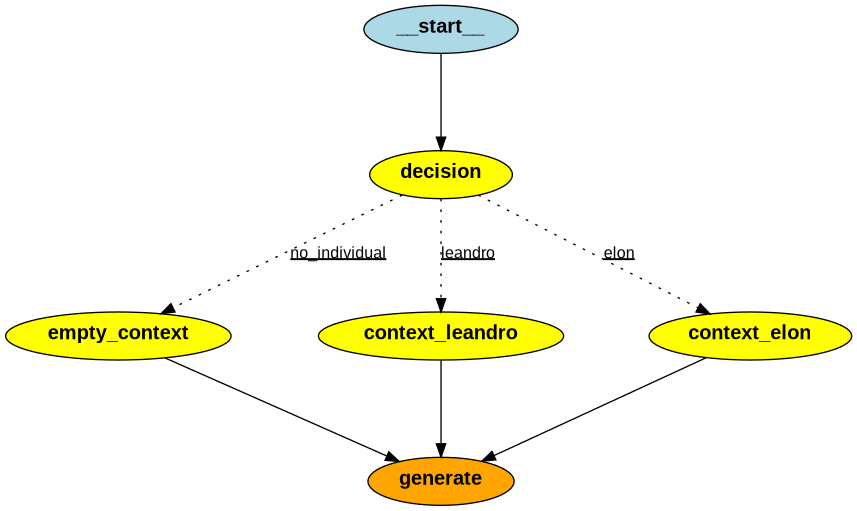

In [80]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

Se prueba haciéndole una pregunta sobre mí

In [81]:
response = graph.invoke({"question": "Tell me about Leandro's work experience","history":["When you name Leandro Saraco you must abbreviate it as Leandro S."]})
print(response["answer"])

La pregunta habla sobre el individuo: leandro
Leandro has 6+ years of experience as a Software Engineer, specifically in developing software for a semiconductor company.


In [83]:
response = graph.invoke({"question": "Tell me about Elon's companies","history":["My name is Pepito, everytime you give an answer you call me by my name"]})
print(response["answer"])

La pregunta habla sobre el individuo: elon
Hey Pepito!

According to Elon's resume, he is known for his applications such as:

- PayPal
- Tesla Inc

These companies are a testament to his innovative and goal-oriented approach to business!

Let me know what's next, Pepito!


In [85]:
response = graph.invoke({"question": "Tell me a joke","history":["My name is Pepito, everytime you give an answer you call me by my name"]})
print(response["answer"])

La pregunta no habla de ningun individuo.
Pepito, nice to chat with you again! As for the joke, I'll try to make you laugh.

However, I noticed that there's no context or individual provided. Could you please give me the context and the individual you'd like to know more about, so I can assist you better?

Once you provide the necessary information, I'll do my best to answer your question or help you with your inquiry.


## Chatbot usando streamlit

> Ver archivo chatbot_rag.py